## **Shielf Insurance Premium Predictor**

**Import Required Libraries**

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor


#### **Data Cleaning & EDA - Part 1**

**Explore Dataset**

In [188]:
df = pd.read_excel("premiums_with_life_style.xlsx")
print(df.shape)
df.head(4)

(10000, 15)


,Age,Gender,Region,Marital_status,Physical_Activity,Stress_Level,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459
3,55,Male,Northeast,Married,High,Medium,3,Overweight,Occasional,Salaried,<10L,9,Thyroid,Silver,21685


In [189]:
df['Age'].dtypes

dtype('int64')

In [190]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Physical_Activity',
       'Stress_Level', 'Number Of Dependants', 'BMI_Category',
       'Smoking_Status', 'Employment_Status', 'Income_Level', 'Income_Lakhs',
       'Medical History', 'Insurance_Plan', 'Annual_Premium_Amount'],
      dtype='object')

**Normalize Column Titles**

In [191]:
df.columns.str.replace(' ','_')

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Physical_Activity',
       'Stress_Level', 'Number_Of_Dependants', 'BMI_Category',
       'Smoking_Status', 'Employment_Status', 'Income_Level', 'Income_Lakhs',
       'Medical_History', 'Insurance_Plan', 'Annual_Premium_Amount'],
      dtype='object')

In [192]:
df.columns = df.columns.str.replace(' ','_').str.lower()

In [193]:
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'physical_activity',
       'stress_level', 'number_of_dependants', 'bmi_category',
       'smoking_status', 'employment_status', 'income_level', 'income_lakhs',
       'medical_history', 'insurance_plan', 'annual_premium_amount'],
      dtype='object')

### **Handle NAN Values**

In [194]:
df.isnull().sum()

age                       0
gender                    0
region                    0
marital_status            0
physical_activity         0
stress_level              0
number_of_dependants      0
bmi_category              0
smoking_status            9
employment_status         7
income_level             18
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [195]:
df[df.income_level.isnull()].sample(4)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
8637,52,Female,Southwest,Married,Low,High,3,Overweight,No Smoking,Freelancer,NaN,3,No Disease,Bronze,15455
8990,44,Male,Northeast,Unmarried,High,Low,1,Normal,Occasional,Salaried,NaN,1,No Disease,Silver,14391
7606,18,Female,Northeast,Unmarried,Medium,Medium,2,Underweight,No Smoking,NaN,NaN,9,No Disease,Silver,8900
8448,51,Male,Southwest,Married,Medium,High,3,Overweight,Occasional,NaN,NaN,7,High blood pressure,Silver,24499


In [196]:
# Since null values are very few compared to dataset, we can just drop them
df.dropna(inplace=True)
df.isnull().sum()
df.shape

(9973, 15)

**Check & Handle Duplicates**

In [197]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [198]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,9973.000000,9973.000000,9973.000000,9973.000000
mean,41.319362,3.195628,23.382232,19503.816705
std,58.044687,21.679565,32.334811,8898.079736
min,18.000000,0.000000,1.000000,3582.000000
25%,24.000000,0.000000,6.000000,11774.000000
50%,37.000000,2.000000,16.000000,19314.000000
75%,50.000000,3.000000,31.000000,26500.000000
max,1178.000000,456.000000,960.000000,45854.000000


**Check Distribution of Numerical Features**

In [199]:
# This is how to fetch all numeric columns in your dataset

df.select_dtypes(['float64', 'int64'])

,age,number_of_dependants,income_lakhs,annual_premium_amount
0,56,2,37,27944
1,38,5,10,21108
2,18,0,9,8459
3,55,3,9,21685
4,22,2,13,15984
...,...,...,...,...
9995,31,5,13,23032
9996,24,0,29,7996
9997,18,0,6,14605
9998,28,0,27,25146


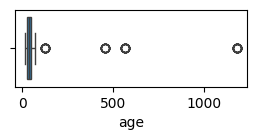

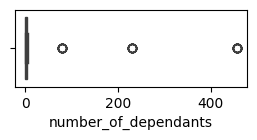

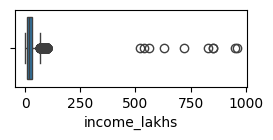

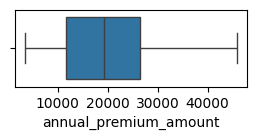

In [200]:
numerical_features = df.select_dtypes(['float64', 'int64']).columns

for feature in numerical_features:
    plt.figure(figsize=(3,1))
    sns.boxplot(x = df[feature])
    

**Treat Outliers in Age Using Threshold (max_Age=100)**

In [201]:
# Using business knowledge of Ages <=100

df[df.age>100].age.unique()

array([ 128, 1178,  567,  456], dtype=int64)

In [202]:
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,9915.000000,9915.000000,9915.000000,9915.000000
mean,37.743621,3.203429,23.400807,19496.715784
std,13.975462,21.742340,32.398236,8899.088302
min,18.000000,0.000000,1.000000,3582.000000
25%,24.000000,0.000000,6.000000,11765.500000
50%,37.000000,2.000000,16.000000,19309.000000
75%,50.000000,3.000000,31.000000,26493.000000
max,72.000000,456.000000,960.000000,45854.000000


**Treat Outliers in Income Using IQR**

<Axes: >

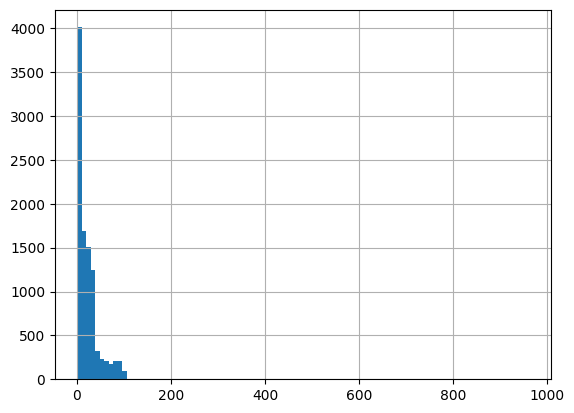

In [203]:
df1['income_lakhs'].hist(bins=100)

In [204]:
df1['income_lakhs'].quantile([0.25,0.75])


0.25     6.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [205]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return lower_bound, upper_bound

In [206]:
get_iqr_bounds(df1.income_lakhs)

# we won't worry on the lower_bound rather on the upper bound, 67, which is not that extreme

(-31.5, 68.5)

In [207]:
# Rather we can choose to set a threshold

quantile_threshold = df1['income_lakhs'].quantile(0.999)
quantile_threshold

136.12000000048283

In [208]:
df1[df1['income_lakhs']>quantile_threshold]

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
361,19,Female,Southeast,Unmarried,Medium,High,1,Underweight,No Smoking,Salaried,> 40L,850,No Disease,Silver,12109
518,47,Male,Southwest,Married,Low,Low,4,Normal,Regular,Self-Employed,> 40L,850,High blood pressure & Heart disease,Gold,36632
1469,32,Male,Southwest,Unmarried,Medium,Medium,1,Underweight,No Smoking,Salaried,> 40L,950,No Disease,Bronze,8992
1576,35,Male,Southwest,Married,Medium,Medium,4,Underweight,Occasional,Salaried,> 40L,830,High blood pressure & Heart disease,Gold,28749
2944,21,Male,Northeast,Unmarried,Medium,Low,1,Underweight,No Smoking,Self-Employed,> 40L,560,No Disease,Silver,10086
3464,21,Female,Southwest,Unmarried,High,High,0,Normal,No Smoking,Self-Employed,> 40L,540,No Disease,Gold,13751
4976,24,Female,Southwest,Unmarried,Medium,High,0,Underweight,No Smoking,Salaried,> 40L,720,No Disease,Silver,11150
5281,18,Female,Southeast,Unmarried,Medium,Medium,0,Normal,Regular,Freelancer,> 40L,520,No Disease,Silver,13204
9021,55,Female,Northeast,Unmarried,Low,Low,0,Overweight,No Smoking,Self-Employed,> 40L,630,Diabetes,Silver,24311
9426,24,Male,Southwest,Unmarried,High,Low,0,Normal,Regular,Self-Employed,> 40L,960,No Disease,Silver,12119


In [209]:
# Since just a total of 10 people has income above the set threshold, we can then decide to drop them

df2 = df1[df1['income_lakhs']<=quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,9905.000000,9905.000000,9905.000000,9905.000000
mean,37.751843,3.205553,22.676325,19499.125088
std,13.974916,21.753158,22.453983,8898.743837
min,18.000000,0.000000,1.000000,3582.000000
25%,24.000000,0.000000,6.000000,11767.000000
50%,37.000000,2.000000,16.000000,19314.000000
75%,50.000000,3.000000,31.000000,26493.000000
max,72.000000,456.000000,100.000000,45854.000000


**Treat Outliers in Income Using IQR**

In [210]:
df2.number_of_dependants.value_counts()

number_of_dependants
0      2606
3      2426
2      1906
1      1418
4      1091
5       411
456      19
78       15
230      13
Name: count, dtype: int64

In [211]:
df2[df2.number_of_dependants>5].shape

(47, 15)

In [212]:
get_iqr_bounds(df2.number_of_dependants)

(-4.5, 7.5)

In [213]:
nod_threshold = df2.number_of_dependants.quantile(0.995)
nod_threshold

5.0

In [214]:
df3 = df2[df2['number_of_dependants']<=nod_threshold].copy()
df3.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,9858.000000,9858.000000,9858.000000,9858.000000
mean,37.764760,1.919963,22.683709,19513.853419
std,13.976268,1.503027,22.453283,8900.593367
min,18.000000,0.000000,1.000000,3582.000000
25%,24.000000,0.000000,6.000000,11777.000000
50%,37.000000,2.000000,16.000000,19331.500000
75%,50.000000,3.000000,31.000000,26505.750000
max,72.000000,5.000000,100.000000,45854.000000


#### **Data Cleaning & EDA - Part 2**

**View Numerical Data on Histogram: Univariate Analysis**

In [215]:
df3.select_dtypes(['float64', 'int64']).columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

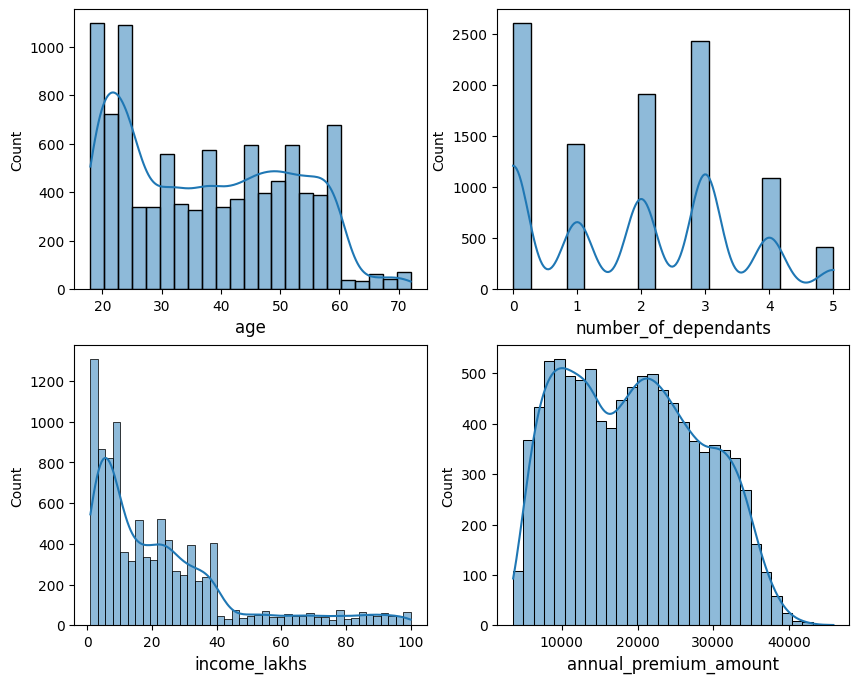

In [216]:
numerical_features = df3.select_dtypes(['float64', 'int64']).columns

n = len(numerical_features)

fig, axes = plt.subplots(int(n/2),2,figsize=(10,8))
axes = axes.flatten()

for i,feature in enumerate(numerical_features):
    sns.histplot(data = df3, x = feature, kde=True, ax=axes[i])
    axes[i].set_xlabel(feature, fontsize=12)

plt.show()

**Bivariate Analysis of Numerical Features w.r.t annual_premium_income**

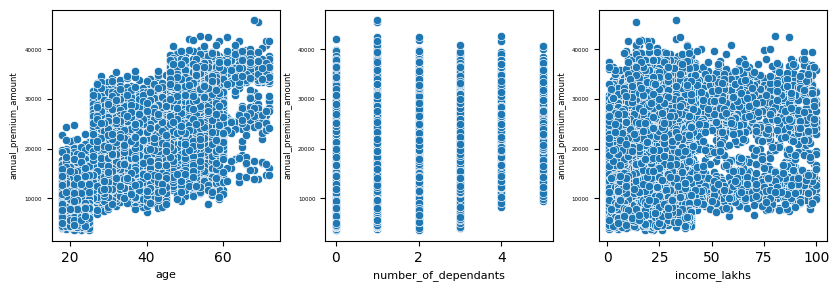

In [217]:
numerical_features = df3.select_dtypes(['float64', 'int64']).columns
bivariate_features = numerical_features.drop('annual_premium_amount')


fig, axes = plt.subplots(1,3,figsize=(10,3))
axes = axes.flatten()

for i,feature in enumerate(bivariate_features):
    sns.scatterplot(data = df3, x=feature, y='annual_premium_amount', ax=axes[i])
    axes[i].set_xlabel(feature, fontsize=8)
    axes[i].set_ylabel('annual_premium_amount', fontsize=6)
    axes[i].tick_params(axis='y', labelsize=4)
for j in range(len(bivariate_features), len(axes)):
    fig.delaxes(axes[j])

plt.show()


**Categorical Columns EDA**

In [218]:
categorical_features = df3.select_dtypes(['object']).columns
categorical_features
for col in categorical_features:
    print(col, ':', df3[col].unique())

gender : ['Female' 'Male']
region : ['Southeast' 'Northeast' 'Southwest' 'Northwest']
marital_status : ['Unmarried' 'Married']
physical_activity : ['Medium' 'Low' 'High']
stress_level : ['Medium' 'High' 'Low']
bmi_category : ['Normal' 'Overweight' 'Obesity' 'Underweight']
smoking_status : ['No Smoking' 'Occasional' 'Regular']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['25L - 40L' '10L - 25L' '<10L' '> 40L']
medical_history : ['High blood pressure' 'No Disease' 'Thyroid'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid' 'Diabetes'
 'Heart disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease']
insurance_plan : ['Gold' 'Silver' 'Bronze']


In [219]:
get_count = df3.gender.value_counts(normalize=True)*100
get_count

gender
Female    59.870156
Male      40.129844
Name: proportion, dtype: float64

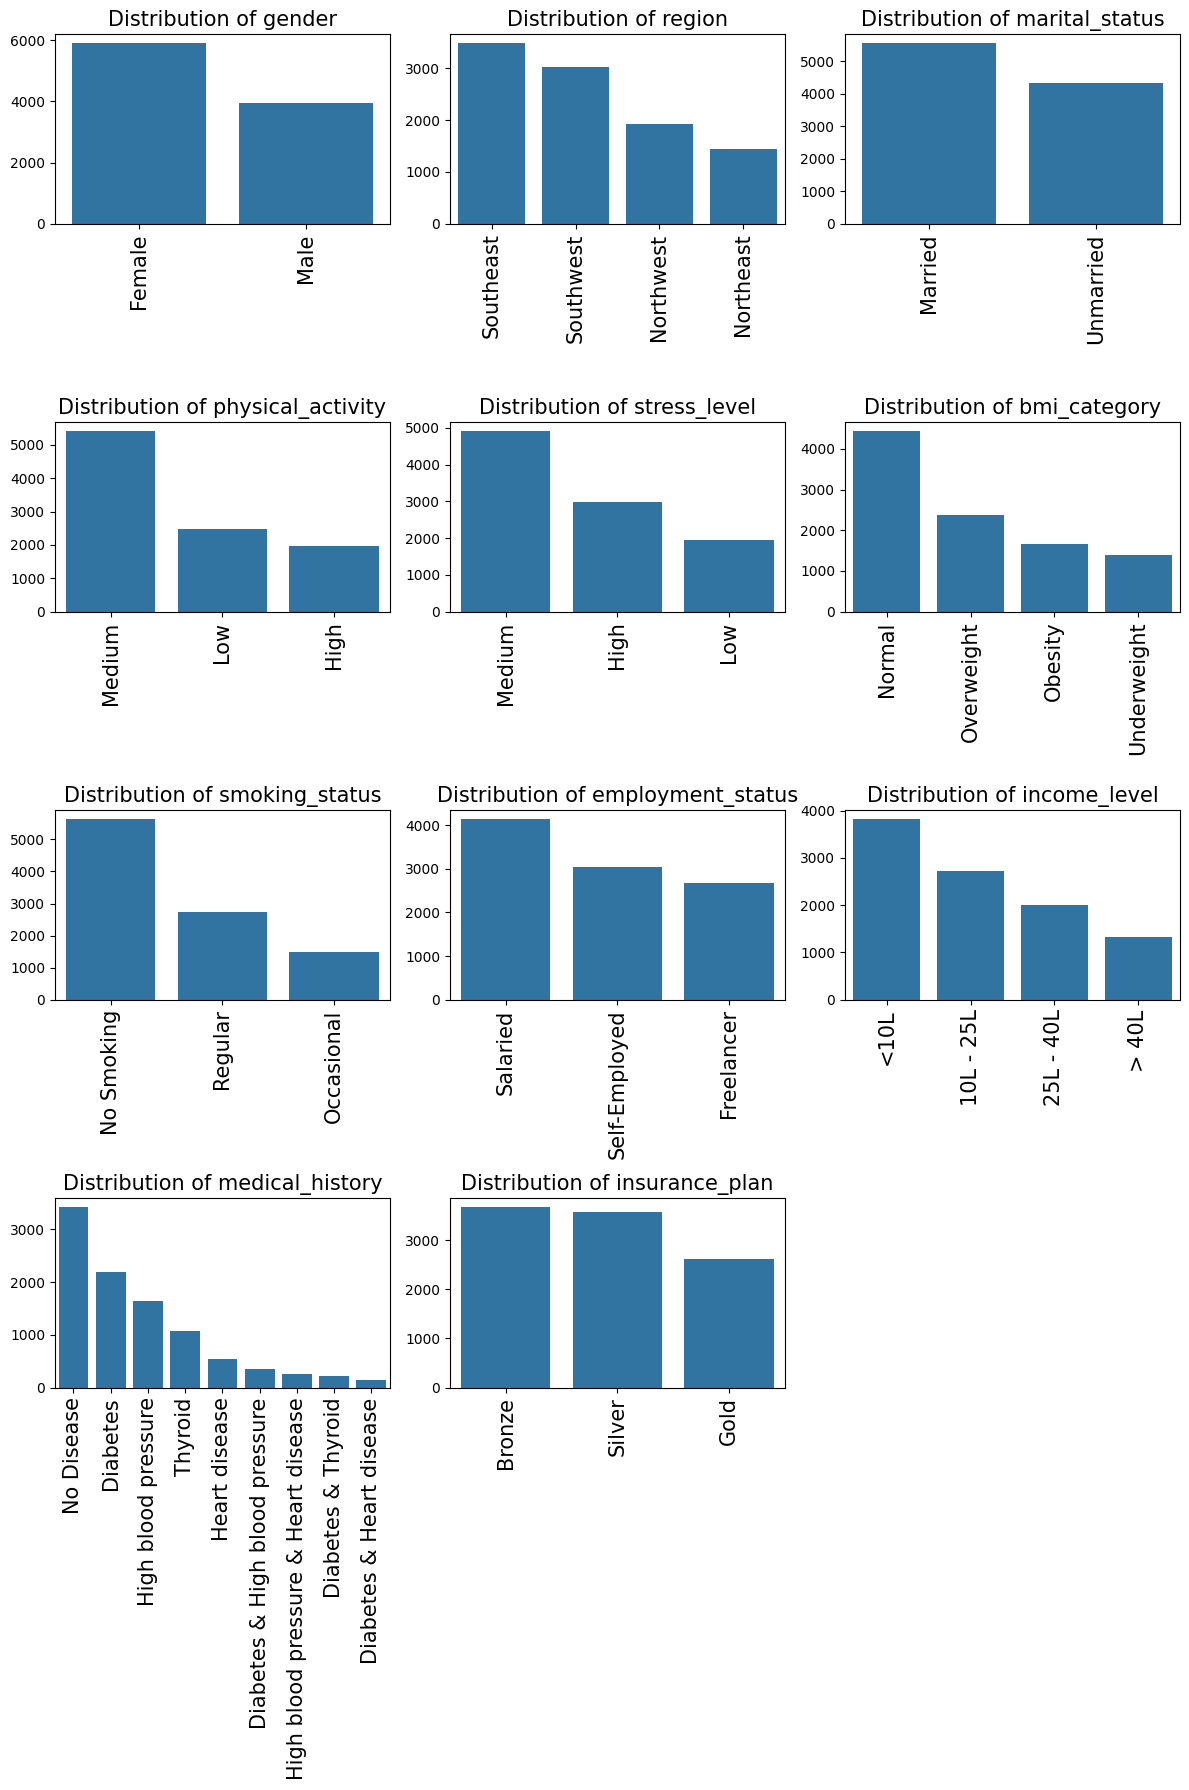

In [220]:
import math
categorical_features = df3.select_dtypes(['object']).columns
n = len(categorical_features)
rows = math.ceil(n / 3)

fig, axes = plt.subplots(rows, 3, figsize=(12,18))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    get_count = df3[col].value_counts()
    sns.barplot(x=get_count.index, y=get_count.values, ax = axes[i])
    axes[i].set_title(f'Distribution of {col}', fontsize=15)
    axes[i].tick_params(axis='x', rotation=90, labelsize=15)
    axes[i].tick_params(axis='y', labelsize=10)
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



**Crosstab ::: Cross Tabulation**

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L          822   909     998
25L - 40L          533   733     733
<10L              2266   184    1366
> 40L               55   788     471


<Axes: xlabel='income_level'>

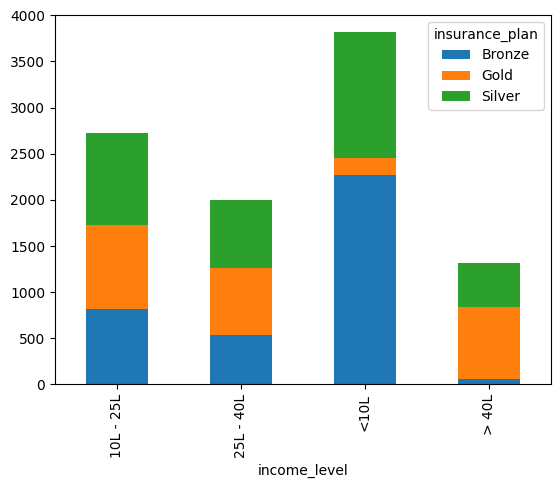

In [221]:
crosstab = pd.crosstab(df3['income_level'], df3['insurance_plan'])
print(crosstab)

crosstab.plot(kind='bar', stacked=True)

<Axes: xlabel='insurance_plan', ylabel='income_level'>

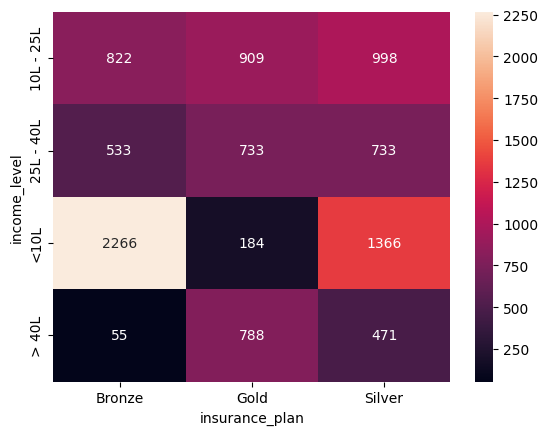

In [222]:
sns.heatmap(crosstab,fmt='d', annot=True)

#### **Feature Engineering: Converting Text to Numbers**

In [223]:
df3.head(2)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108


In [224]:
df3.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
physical_activity        0
stress_level             0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

**Normalizing medical_history column**

In [225]:
df3.medical_history.unique()

array(['High blood pressure', 'No Disease', 'Thyroid',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes', 'Heart disease', 'Diabetes & High blood pressure',
       'Diabetes & Heart disease'], dtype=object)

In [226]:
risk_scores = {
    'diabetes': 6,
    'heart disease': 8,
    'high blood pressure': 6,
    'thyroid': 5,
    'no disease': 0,
    'none': 0
}

df3[['disease1', 'disease2']] = df3['medical_history'].str.split('&', expand=True).apply(lambda x: x.str.strip().str.lower())
df3.head(4)




,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944,high blood pressure,None
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108,no disease,None
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459,no disease,None
3,55,Male,Northeast,Married,High,Medium,3,Overweight,Occasional,Salaried,<10L,9,Thyroid,Silver,21685,thyroid,None


In [227]:
df3.isnull().sum()

age                         0
gender                      0
region                      0
marital_status              0
physical_activity           0
stress_level                0
number_of_dependants        0
bmi_category                0
smoking_status              0
employment_status           0
income_level                0
income_lakhs                0
medical_history             0
insurance_plan              0
annual_premium_amount       0
disease1                    0
disease2                 8882
dtype: int64

In [228]:
df3[df3['disease2'].isnull()].shape

(8882, 17)

In [229]:
df3['disease1'] = df3['disease1'].fillna('none')
df3['disease2'] = df3['disease2'].fillna('none')
df3['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df3['total_risk_score'] += df3[disease].map(risk_scores)



In [230]:
df3.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
physical_activity        0
stress_level             0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
disease1                 0
disease2                 0
total_risk_score         0
dtype: int64

**Scale Total Risk Score with MinMaxScaler Approach**

In [232]:
max_score = df3['total_risk_score'].max()
min_score = df3['total_risk_score'].min()
df3['normalized_risk_score'] = (df3['total_risk_score'] - min_score)/(max_score - min_score)
df3.head(4)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944,high blood pressure,none,6,0.428571
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108,no disease,none,0,0.000000
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459,no disease,none,0,0.000000
3,55,Male,Northeast,Married,High,Medium,3,Overweight,Occasional,Salaried,<10L,9,Thyroid,Silver,21685,thyroid,none,5,0.357143


**Normalizing physical_activity & Stress_Level column**

In [233]:
df3.head(4)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944,high blood pressure,none,6,0.428571
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108,no disease,none,0,0.000000
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459,no disease,none,0,0.000000
3,55,Male,Northeast,Married,High,Medium,3,Overweight,Occasional,Salaried,<10L,9,Thyroid,Silver,21685,thyroid,none,5,0.357143


In [234]:
df3['physical_activity']= df3['physical_activity'].map({'High': 0, 'Medium': 1, 'Low': 4})


In [235]:
df3.head(4)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,56,Female,Southeast,Unmarried,1,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944,high blood pressure,none,6,0.428571
1,38,Female,Northeast,Married,4,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108,no disease,none,0,0.000000
2,18,Female,Southwest,Unmarried,1,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459,no disease,none,0,0.000000
3,55,Male,Northeast,Married,0,Medium,3,Overweight,Occasional,Salaried,<10L,9,Thyroid,Silver,21685,thyroid,none,5,0.357143


In [236]:
df3['stress_level']= df3['stress_level'].map({'High': 4, 'Medium': 1, 'Low': 0})

In [237]:
df3.head(4)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,56,Female,Southeast,Unmarried,1,1,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944,high blood pressure,none,6,0.428571
1,38,Female,Northeast,Married,4,4,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108,no disease,none,0,0.000000
2,18,Female,Southwest,Unmarried,1,4,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459,no disease,none,0,0.000000
3,55,Male,Northeast,Married,0,1,3,Overweight,Occasional,Salaried,<10L,9,Thyroid,Silver,21685,thyroid,none,5,0.357143


In [238]:
df3['life_style_risk_score'] = df3['physical_activity'] + df3['stress_level']
df3.head(4)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score,life_style_risk_score
0,56,Female,Southeast,Unmarried,1,1,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944,high blood pressure,none,6,0.428571,2
1,38,Female,Northeast,Married,4,4,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108,no disease,none,0,0.000000,8
2,18,Female,Southwest,Unmarried,1,4,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459,no disease,none,0,0.000000,5
3,55,Male,Northeast,Married,0,1,3,Overweight,Occasional,Salaried,<10L,9,Thyroid,Silver,21685,thyroid,none,5,0.357143,1


<Axes: xlabel='life_style_risk_score', ylabel='Count'>

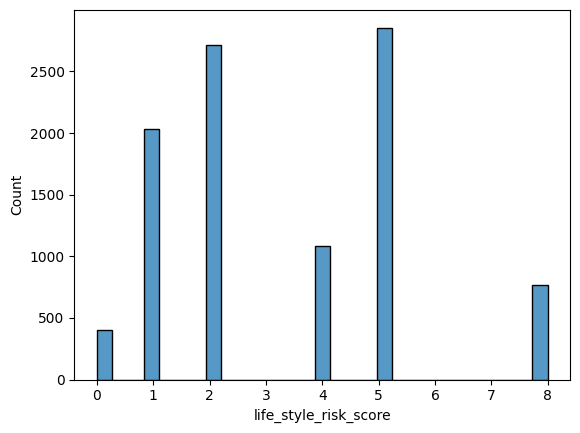

In [285]:
sns.histplot(df3.life_style_risk_score)

In [239]:
df3.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
physical_activity        0
stress_level             0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
disease1                 0
disease2                 0
total_risk_score         0
normalized_risk_score    0
life_style_risk_score    0
dtype: int64

**Encode insurance_plan column**

In [240]:
df3.insurance_plan.unique()

# # It's more like an ordinal categorical variable

array(['Gold', 'Silver', 'Bronze'], dtype=object)

In [241]:
df3['insurance_plan'] = df3.insurance_plan.map({'Bronze':1, 'Silver':2, 'Gold':3})
df3.head(4)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score,life_style_risk_score
0,56,Female,Southeast,Unmarried,1,1,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,3,27944,high blood pressure,none,6,0.428571,2
1,38,Female,Northeast,Married,4,4,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,2,21108,no disease,none,0,0.000000,8
2,18,Female,Southwest,Unmarried,1,4,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,1,8459,no disease,none,0,0.000000,5
3,55,Male,Northeast,Married,0,1,3,Overweight,Occasional,Salaried,<10L,9,Thyroid,2,21685,thyroid,none,5,0.357143,1


In [173]:
# df2[df2['normalized_risk_score'].isnull()]

**Encode income_level column**

In [242]:
df3.income_level.unique()

array(['25L - 40L', '10L - 25L', '<10L', '> 40L'], dtype=object)

In [243]:
df3['income_level'] = df3.income_level.map({'<10L':1, '10L - 25L':2, '25L - 40L':3, '> 40L':4})

In [244]:
df3.head(4)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score,life_style_risk_score
0,56,Female,Southeast,Unmarried,1,1,2,Normal,No Smoking,Self-Employed,3,37,High blood pressure,3,27944,high blood pressure,none,6,0.428571,2
1,38,Female,Northeast,Married,4,4,5,Overweight,Occasional,Freelancer,2,10,No Disease,2,21108,no disease,none,0,0.000000,8
2,18,Female,Southwest,Unmarried,1,4,0,Normal,No Smoking,Freelancer,1,9,No Disease,1,8459,no disease,none,0,0.000000,5
3,55,Male,Northeast,Married,0,1,3,Overweight,Occasional,Salaried,1,9,Thyroid,2,21685,thyroid,none,5,0.357143,1


**Encode Nominal columns: One Hot Encoding**

In [245]:
nominal_cols = ['gender',	'region',	'marital_status','bmi_category', 'smoking_status', 'employment_status']
df4 = pd.get_dummies(df3, columns = nominal_cols, drop_first = True, dtype=int)
df4.head(4)

,age,physical_activity,stress_level,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,56,1,1,2,3,37,High blood pressure,3,27944,high blood pressure,...,1,0,1,0,0,0,0,0,0,1
1,38,4,4,5,2,10,No Disease,2,21108,no disease,...,0,0,0,0,1,0,1,0,0,0
2,18,1,4,0,1,9,No Disease,1,8459,no disease,...,0,1,1,0,0,0,0,0,0,0
3,55,0,1,3,1,9,Thyroid,2,21685,thyroid,...,0,0,0,0,1,0,1,0,1,0


In [286]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9858 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              9858 non-null   int64  
 1   physical_activity                9858 non-null   int64  
 2   stress_level                     9858 non-null   int64  
 3   number_of_dependants             9858 non-null   int64  
 4   income_level                     9858 non-null   int64  
 5   income_lakhs                     9858 non-null   int64  
 6   medical_history                  9858 non-null   object 
 7   insurance_plan                   9858 non-null   int64  
 8   annual_premium_amount            9858 non-null   int64  
 9   disease1                         9858 non-null   object 
 10  disease2                         9858 non-null   object 
 11  total_risk_score                 9858 non-null   int64  
 12  normalized_risk_score    

#### **Feature Engineering: Converting Text to Numbers**

In [246]:
df5 = df4.drop(['medical_history', 'disease1', 'disease2', 'total_risk_score','physical_activity', 'stress_level'], axis=1)

In [247]:
df5.isnull().sum()

age                                0
number_of_dependants               0
income_level                       0
income_lakhs                       0
insurance_plan                     0
annual_premium_amount              0
normalized_risk_score              0
life_style_risk_score              0
gender_Male                        0
region_Northwest                   0
region_Southeast                   0
region_Southwest                   0
marital_status_Unmarried           0
bmi_category_Obesity               0
bmi_category_Overweight            0
bmi_category_Underweight           0
smoking_status_Occasional          0
smoking_status_Regular             0
employment_status_Salaried         0
employment_status_Self-Employed    0
dtype: int64

**Feature Selection: Correlation and VIF**

**Correlation**

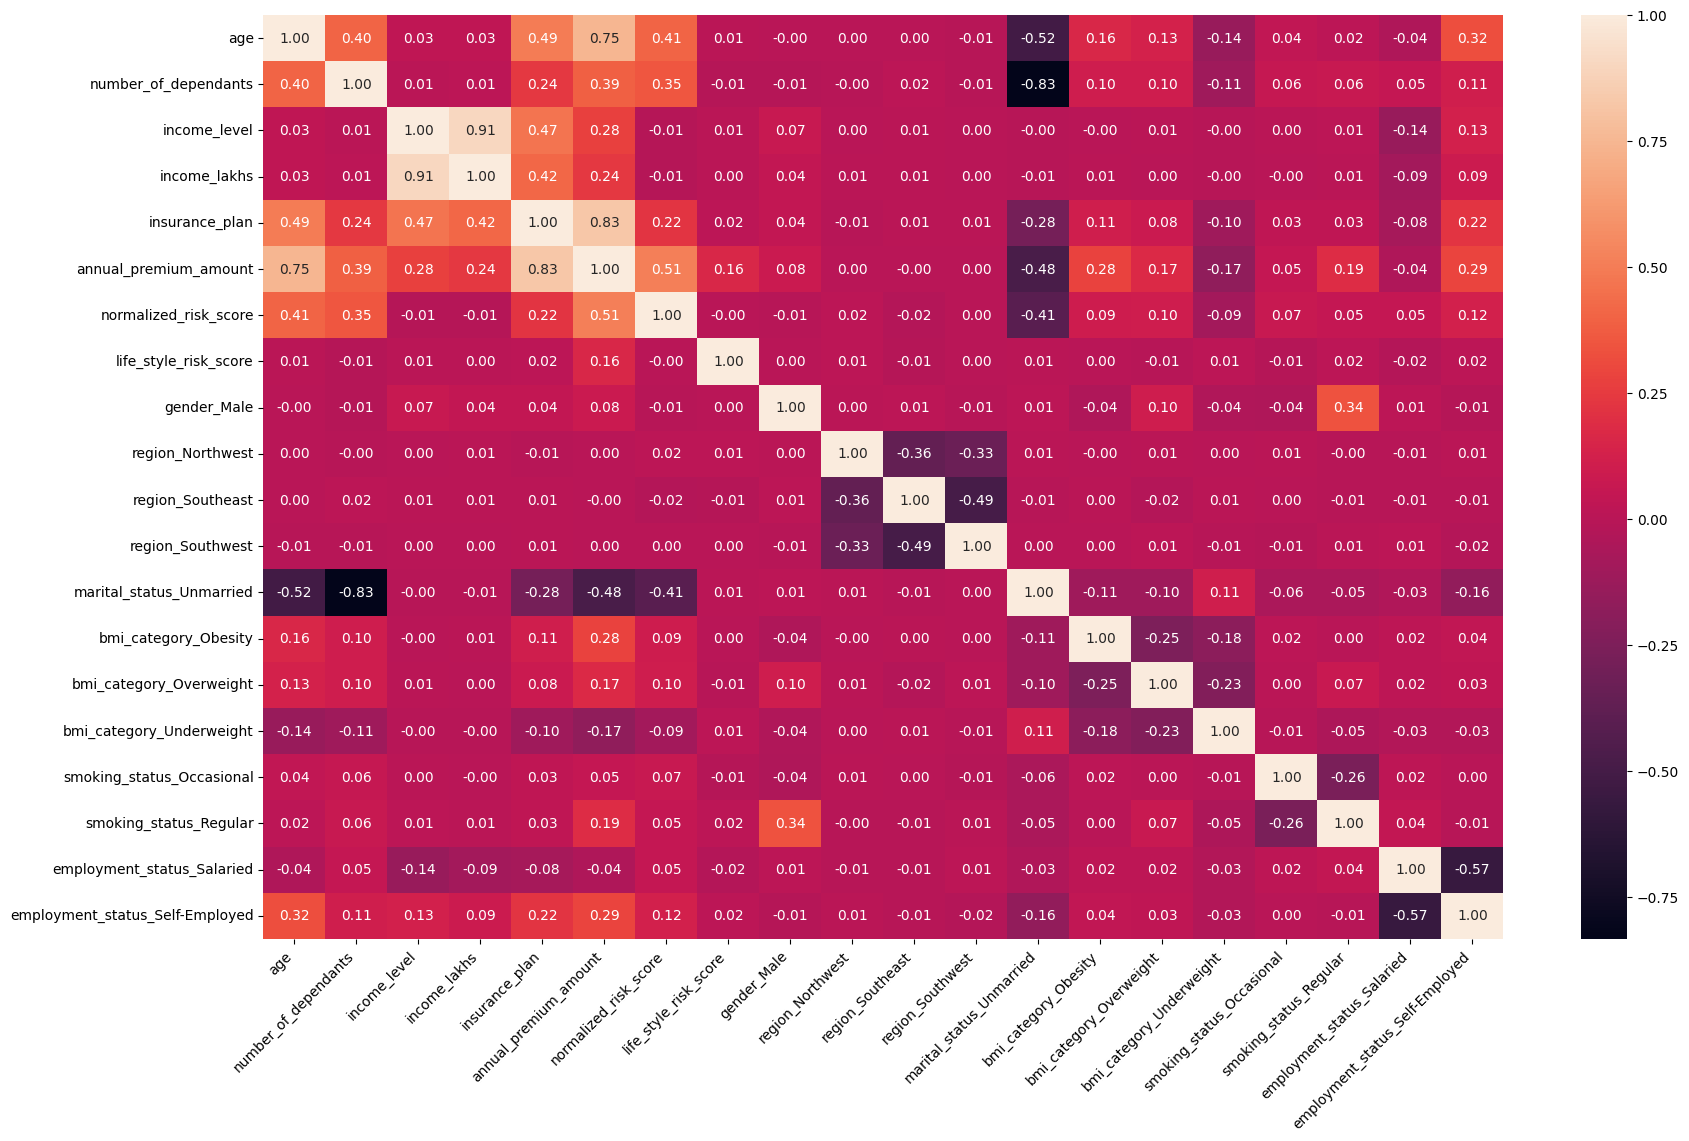

In [248]:
cm = df5.corr()
plt.figure(figsize=(20,12))
sns.heatmap(cm, fmt='.2f', annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

**VIF - Process**

In [249]:
df5.head(4)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,life_style_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,56,2,3,37,3,27944,0.428571,2,0,0,1,0,1,0,0,0,0,0,0,1
1,38,5,2,10,2,21108,0.000000,8,0,0,0,0,0,0,1,0,1,0,0,0
2,18,0,1,9,1,8459,0.000000,5,0,0,0,1,1,0,0,0,0,0,0,0
3,55,3,1,9,2,21685,0.357143,1,1,0,0,0,0,0,1,0,1,0,1,0


In [250]:
X = df5.drop('annual_premium_amount', axis='columns')
y = df5['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ['age','income_lakhs', 'number_of_dependants' ,'income_level', 'insurance_plan', 'life_style_risk_score']
scaler = MinMaxScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head(4)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,life_style_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.703704,0.4,0.666667,0.363636,1.0,0.428571,0.250,0,0,1,0,1,0,0,0,0,0,0,1
1,0.370370,1.0,0.333333,0.090909,0.5,0.000000,1.000,0,0,0,0,0,0,1,0,1,0,0,0
2,0.000000,0.0,0.000000,0.080808,0.0,0.000000,0.625,0,0,0,1,1,0,0,0,0,0,0,0
3,0.685185,0.6,0.000000,0.080808,0.5,0.357143,0.125,1,0,0,0,0,0,1,0,1,0,1,0


In [251]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

In [252]:
calculate_vif(X)

,Column,VIF
0,age,5.541063
1,number_of_dependants,5.320401
2,income_level,12.548788
3,income_lakhs,10.947288
4,insurance_plan,4.147071
5,normalized_risk_score,3.001706
6,life_style_risk_score,3.110913
7,gender_Male,1.910118
8,region_Northwest,2.082989
9,region_Southeast,2.952809


In [253]:
# Due to high Correlation between income_level & income_lakhs, 
# We drop the feature with the highest value; income_level

calculate_vif(X.drop('income_level', axis='columns'))

,Column,VIF
0,age,5.488217
1,number_of_dependants,5.306542
2,income_lakhs,2.450579
3,insurance_plan,3.875312
4,normalized_risk_score,3.001684
5,life_style_risk_score,3.110034
6,gender_Male,1.901611
7,region_Northwest,2.082813
8,region_Southeast,2.951877
9,region_Southwest,2.678296


In [254]:
X_reduced = X.drop('income_level', axis='columns')
X_reduced.head(4)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,life_style_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.703704,0.4,0.363636,1.0,0.428571,0.250,0,0,1,0,1,0,0,0,0,0,0,1
1,0.370370,1.0,0.090909,0.5,0.000000,1.000,0,0,0,0,0,0,1,0,1,0,0,0
2,0.000000,0.0,0.080808,0.0,0.000000,0.625,0,0,0,1,1,0,0,0,0,0,0,0
3,0.685185,0.6,0.080808,0.5,0.357143,0.125,1,0,0,0,0,0,1,0,1,0,1,0


### **Model Training**

In [255]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (6900, 18)
X_test:  (2958, 18)
y_train:  (6900,)
y_test:  (2958,)


**Train Linear Regression**

In [256]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score, test_score

# Doing a train_score is to check the performance of both train and test dataset.
# When tran_set is overfitting, the score will be higher than test_set.
# There's no overfitting.

(0.9586426437876246, 0.9572516785678009)

In [287]:
X_test.shape

(2958, 18)

In [258]:
model_lr.intercept_

3892.501665390886

In [288]:
np.set_printoptions(suppress=True, precision=6)
model_lr.coef_

array([10675.837861,  -671.110352,  -708.275605, 13311.846824,
        6521.438689,  4724.386632,    11.961022,    77.061876,
          88.325309,    -9.701258,  -820.804958,  4166.09646 ,
        2119.215673,   413.650051,  1159.508746,  3116.482686,
          17.894652,   382.995584])

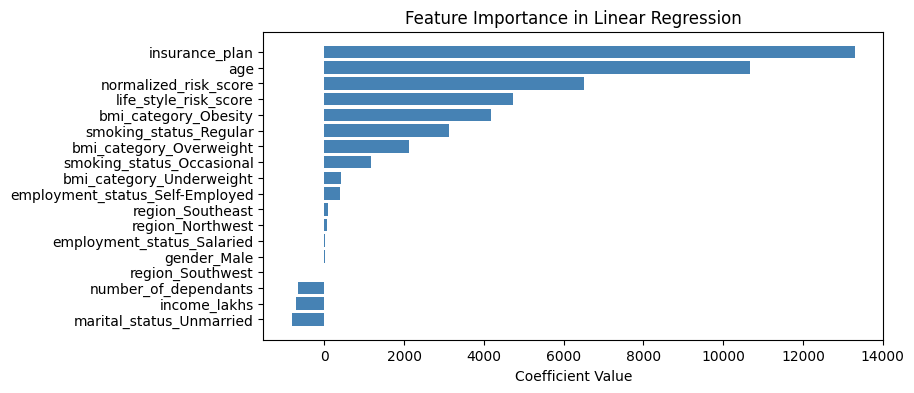

In [260]:
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])
coef_df_sorted = coef_df.sort_values(by='Coefficients',ascending=True)
coef_df_sorted

plt.figure(figsize=(8,4))
plt.barh(coef_df_sorted.index, coef_df_sorted['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

In [261]:
model_rg = Ridge()
model_rg.fit(X_train, y_train)
train_score = model_rg.score(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score, test_score

(0.958641720188849, 0.9572551952240952)

In [290]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score, test_score

(0.9896838758610969, 0.9890376073387469)

**Applying RandomSearchCV for Best Hyperparameter to Fine Tune Model**

In [291]:
model_xgb = XGBRegressor()
params_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3,4,5]
}

random_search = RandomizedSearchCV(model_xgb, params_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
print(random_search.best_params_)
random_search.best_score_


{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}


0.9922216974736728

In [292]:
best_model = random_search.best_estimator_

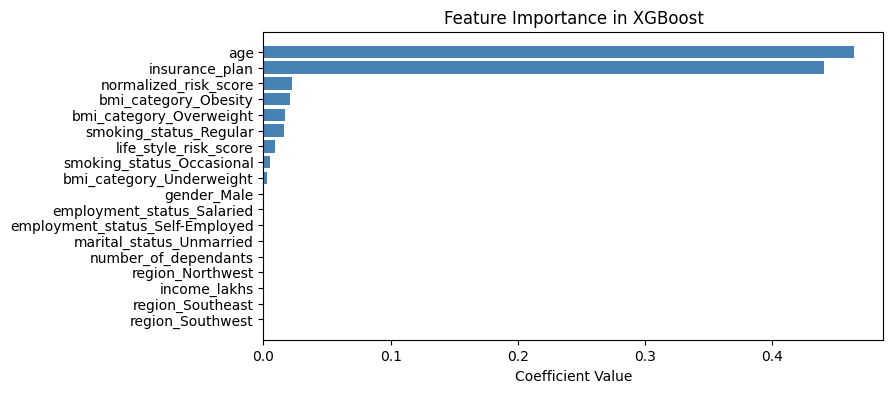

In [293]:
feature_importances = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])
coef_df_sorted = coef_df.sort_values(by='Coefficients',ascending=True)
coef_df_sorted

plt.figure(figsize=(8,4))
plt.barh(coef_df_sorted.index, coef_df_sorted['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

### **Error Analysis**

In [294]:
# Let's check the level of error margin between the y_test and y_pred
y_pred = best_model.predict(X_test)

residuals = y_pred-y_test
residuals_pct = residuals*100/y_test

results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct
})
results_df.head(4)

,actual,predicted,diff,diff_pct
3021,13354,12299.464844,-1054.535156,-7.896774
6049,10701,11454.474609,753.474609,7.041161
6146,15146,16052.226562,906.226562,5.983273
6418,8743,9204.415039,461.415039,5.277537


Text(0.5, 1.0, 'Distribution of Residuals')

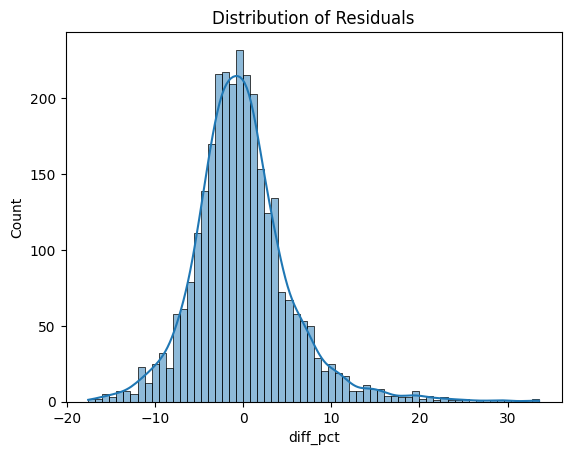

In [297]:
# It will be useful to see the distribution of the margin
sns.histplot(results_df['diff_pct'], kde=True)
plt.title("Distribution of Residuals")

In [298]:
# Having an error margin as high as 80% is not a good one

extreme_error_threshold = 10
extreme_results_df = results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]
extreme_results_df

,actual,predicted,diff,diff_pct
8330,10733,9626.998047,-1106.001953,-10.304686
7800,9632,8511.195312,-1120.804688,-11.636261
3617,12304,10913.647461,-1390.352539,-11.300004
9814,6655,5881.623047,-773.376953,-11.620991
1377,18894,16937.443359,-1956.556641,-10.355439
...,...,...,...,...
1276,13728,15873.284180,2145.284180,15.627070
7504,6985,6072.784668,-912.215332,-13.059633
4942,10930,9631.113281,-1298.886719,-11.883685
5574,10071,11220.883789,1149.883789,11.417772


In [300]:
results_df.shape

(2958, 4)

In [301]:
# Percentage of predictions with %_error above 10%
extreme_error_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

7.234617985125085

There is about 7.2% extreme errors.